![NASAASO](Images/ASOInc_QuandaryPeak_web.jpg)

# Retreiving, Processing, and Analyzing NASA Airborne Snow Observatory (ASO) SWE data product

In this exercise, the user will programatically retreive, process, and spatio temporally analyze swe from NASA ASO missions


# 1. Create Map for Watershed for USGS Station ID
The following code uses the pynhd and folium packages to create an interactive map of a watershed from a USGS gauge ID.

In our exercise, we are tasked with identifying all SNOTEL sites upstream of Hetch Hetchy Reservoir on the Tuolumne River. The user can search for "USGS streamflow Tuolumne River" and serveral locations will pop up. Site [11274790](https://waterdata.usgs.gov/monitoring-location/11274790/#dataTypeId=continuous-00065-0&period=P7D&showMedian=false) is the site of interest for this assessment 

In [3]:
from pynhd import NLDI, WaterData, NHDPlusHR, GeoConnex
import geopandas as gpd
import pandas as pd
from supporting_scripts import ASOget, dataprocessing, mapping, SSWEET, get_Elevation
from shapely.geometry import box, Polygon
import os
import datetime
import matplotlib.pyplot as plt
import numpy as np
import zipfile
import os
import warnings
warnings.filterwarnings("ignore")


Define the watershed outlet using NWIS site id. Create a map object that we'll add layers to.

In [ ]:
nldi = NLDI()
usgs_gage_id = "11274790" # NWIS id for Tuolumne river at the mouth of Hetch Hetchy Reservoir

Collect watershed and reach vectors using the pynhd module.

In [ ]:
nldi = NLDI()

#Getting basin geometry
print('Collecting basins...', end='')
basin = nldi.get_basins(usgs_gage_id)
if not os.path.exists('files'):
    os.makedirs('files')
basin.to_file("files/TuolumneRiverBasin.shp")
print('done')

site_feature = nldi.getfeature_byid("nwissite", f"USGS-{usgs_gage_id}")
upstream_network = nldi.navigate_byid(
    "nwissite", f"USGS-{usgs_gage_id}", "upstreamMain", "flowlines", distance=9999
)

Create and interactive map to display the watershed.

In [ ]:
# create map
mapping.basin_mapping(basin, site_feature)

![Basin](Images/basin.png)

# 2. Retrieve NASA ASO SWE data product for basin of interest

note*, new users will have to [create a .netrc file](https://earthaccess.readthedocs.io/en/latest/howto/authenticate/):

import earthaccess

earthaccess.login(persist=True)

*note, this script can time some time to process(~10 minutes), is prone to loosing html connection, and will grab any NASA ASO Image within the bounding box of your basin of interest, making the reproduction of this code tedious.

In the spirit of the module, ee have QA/QC'd these for you, which we zip and include for you in this repository.

In [ ]:
# import earthaccess https://earthaccess.readthedocs.io/en/latest/howto/authenticate/
# earthaccess.login(persist=True)

# Inputs for fetching ASO data for a region
short_name = 'ASO_50M_SWE'
version = '1'
time_start = '2013-04-02T00:00:00Z'
time_end = '2019-07-19T23:59:59Z'
output_res = 1000 #desired spatial resoultion in meters (m)
directory = "Raw_ASO_Data"
basinname = 'Tuolumne'

#Get ASO data
folder_name = f"files/ASO/{basinname}/{directory}"
data_tool = ASOget.ASODownload(short_name, version)
b_box = data_tool.BoundingBox(basin)  
url_list = data_tool.cmr_search(time_start, time_end, basin, b_box)
data_tool.cmr_download(folder_name, basinname)

#Convert ASO tifs to parquet
data_processor = ASOget.ASODataProcessing()
data_processor.convert_tiff_to_parquet_multiprocess(directory, output_res, basinname) 

Below is the code to unzip the preprosed ASO images and continue the hydrolearn activity

In [4]:
output_res = 1000 #desired spatial resoultion in meters (m)
basinname = 'Tuolumne'

# Path to the zip file
zip_file_path = f"files/ASO/{basinname}/{output_res}M_SWE_parquet.zip"


# Path to the directory where you want to extract the files
extract_to_path = f"files/ASO/{basinname}/{output_res}M_SWE_parquet/"

# Ensure the extraction directory exists
os.makedirs(extract_to_path, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_path)

print(f"Files have been extracted to {extract_to_path}")

Files have been extracted to files/ASO/Tuolumne/1000M_SWE_parquet/


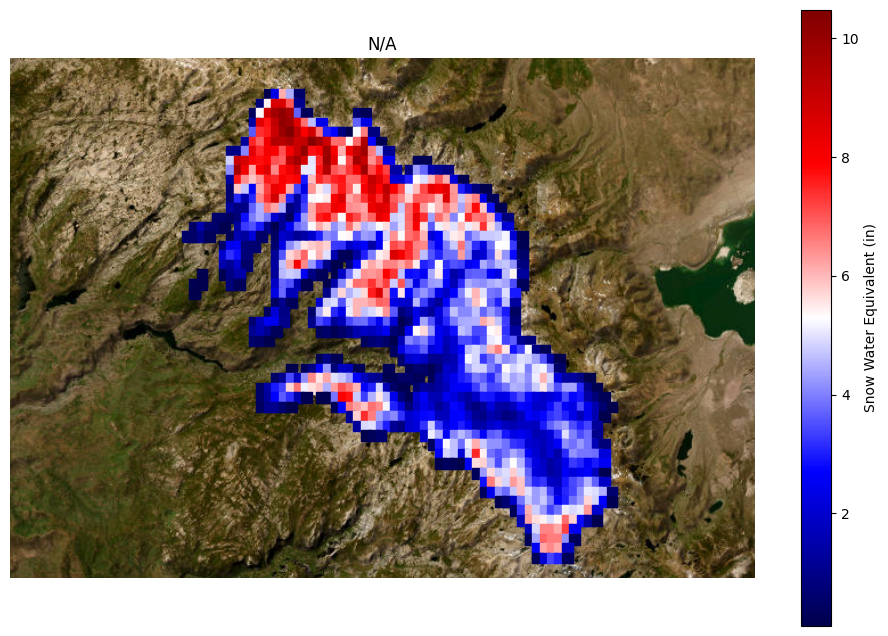

,cen_lat,cen_lon,swe_m,cell_id,swe_in
90,38.180854,-119.612254,0.003378,Tuolumne_1000M_38.181_-119.612,0.133003
91,38.180854,-119.603254,0.058481,Tuolumne_1000M_38.181_-119.603,2.302395
92,38.180854,-119.594254,0.154967,Tuolumne_1000M_38.181_-119.594,6.101071
93,38.180854,-119.585254,0.113126,Tuolumne_1000M_38.181_-119.585,4.453776
94,38.180854,-119.576254,0.013564,Tuolumne_1000M_38.181_-119.576,0.533997
...,...,...,...,...,...
3507,37.739854,-119.288254,0.006328,Tuolumne_1000M_37.74_-119.288,0.249134
3508,37.739854,-119.279254,0.051581,Tuolumne_1000M_37.74_-119.279,2.030747
3509,37.739854,-119.270254,0.086607,Tuolumne_1000M_37.74_-119.27,3.409709
3510,37.739854,-119.261254,0.077314,Tuolumne_1000M_37.74_-119.261,3.043876


In [6]:
cmap = 'seismic' # use seismic for error, viridis or blues for preds/obs
var =  'swe_in' #'error'
savfig = True
variant = 'World_Imagery'
markersize = 60
swethres = 0.1
plttitle = 'N/A'

#Get all file names for ASO images in Tuolumne river basin
files = [f for f in os.listdir(f"files/ASO/{basinname}/{output_res}M_SWE_parquet/") if os.path.isfile(os.path.join(f"files/ASO/{basinname}/{output_res}M_SWE_parquet/", f))]
files = [files[0]]

SSWEET.SpatialAnalysis(files, basinname, output_res, markersize, cmap, var,variant,swethres,plttitle, pltfig = True, savfig=False)

# 3. Generate spatiotemporal average SWE values

Apply methods to determine the patial mean/median SWE for the Tuolumne watershed above hetch hetchy reservoir for a specific time of year (e.g., Peak SWE)

In [38]:
basinname = 'Tuolumne'
output_res = 1000 #desired spatial resoultion in meters (m)
 # get files of interest
begdate = 325 #march 25th
enddate = 407 #april 7th
filename = f"{basinname}_median_SWE_04-01.parquet"
decround = 2

MedianSWE_df = dataprocessing.Spatial_median_SWE_df(output_res, basinname, begdate, enddate, filename,decround,  save = True)
MedianSWE_df

Number of locations with median SWE: 2914, dropped 0 locations because of only 1 observation


,cen_lat,cen_lon,location,median_SWE_m,median_SWE_in
542,38.18,-119.59,Tuolumne_1000M_38.18_-119.59,0.204144,8.037175
543,38.18,-119.58,Tuolumne_1000M_38.18_-119.58,0.021340,0.840176
625,38.17,-119.60,Tuolumne_1000M_38.17_-119.6,0.461101,18.153595
626,38.17,-119.59,Tuolumne_1000M_38.17_-119.59,0.307973,12.124934
627,38.17,-119.58,Tuolumne_1000M_38.17_-119.58,0.042705,1.681314
...,...,...,...,...,...
3582,37.73,-119.23,Tuolumne_1000M_37.73_-119.23,0.000000,0.000000
3584,37.73,-119.22,Tuolumne_1000M_37.73_-119.22,0.000000,0.000000
3585,37.73,-119.21,Tuolumne_1000M_37.73_-119.21,0.000000,0.000000
3586,37.73,-119.20,Tuolumne_1000M_37.73_-119.2,0.000000,0.000000


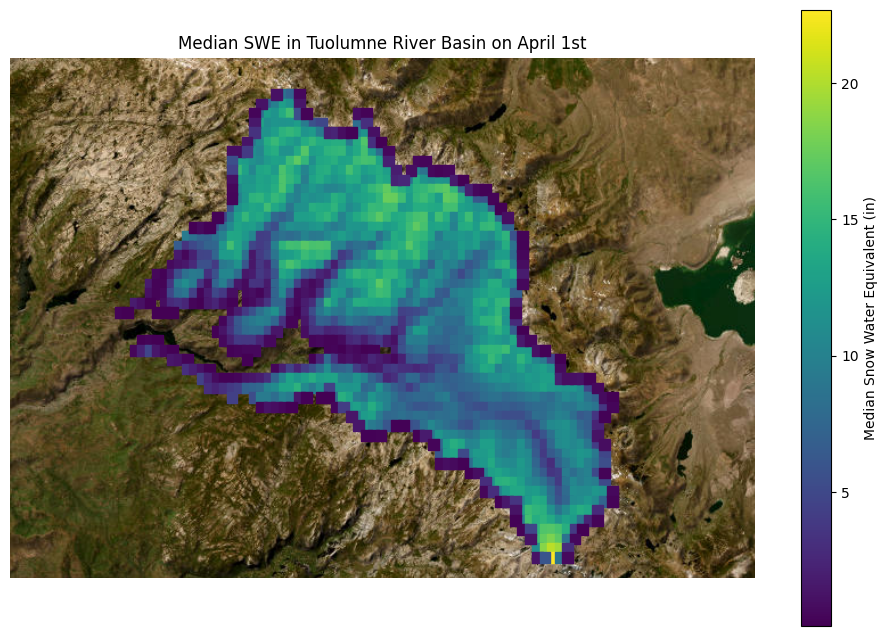

,cen_lat,cen_lon,location,median_SWE_m,median_SWE_in
92,38.181,-119.594,Tuolumne_1000M_38.181_-119.594,0.223841,8.812656
93,38.181,-119.585,Tuolumne_1000M_38.181_-119.585,0.184447,7.261694
159,38.172,-119.612,Tuolumne_1000M_38.172_-119.612,0.186021,7.323656
160,38.172,-119.603,Tuolumne_1000M_38.172_-119.603,0.248937,9.800689
161,38.172,-119.594,Tuolumne_1000M_38.172_-119.594,0.320930,12.635045
...,...,...,...,...,...
3442,37.749,-119.252,Tuolumne_1000M_37.749_-119.252,0.076438,3.009364
3507,37.740,-119.288,Tuolumne_1000M_37.74_-119.288,0.031178,1.227488
3508,37.740,-119.279,Tuolumne_1000M_37.74_-119.279,0.154751,6.092565
3510,37.740,-119.261,Tuolumne_1000M_37.74_-119.261,0.221500,8.720476


In [9]:
#Plot median SWE
basinname = 'Tuolumne'
output_res = 1000 #desired spatial resoultion in meters (m)
 # get files of interest
filename = [f"{basinname}_median_SWE_04-01.parquet"]
cmap = 'viridis' # use seismic for error, viridis or blues for preds/obs
var =  'median_SWE_in' #'error'
savfig = True
variant = 'World_Imagery'
markersize = 60
swethres = 0.1
plttitle = 'Median SWE in Tuolumne River Basin on April 1st'

SSWEET.SpatialAnalysis(filename, basinname, output_res, markersize, cmap, var,variant,swethres,plttitle, pltfig = True, savfig=False)

# 4. Spatially compare a year of interest to the historical swe value


In [ ]:
basinname = 'Tuolumne'
output_res = 1000 #desired spatial resoultion in meters (m)
medianSWEfile = f"{basinname}_median_SWE_04-01.parquet"
date = '20190324' #date of interest
WYSWEfile = f"ASO_{output_res}M_SWE_{date}.parquet"
swedifffilename = f"{basinname}_SWEDiff_{date}.parquet"
decround = 2

df = dataprocessing.SWE_diff(basinname, output_res, medianSWEfile, WYSWEfile,decround,swedifffilename, save=True)


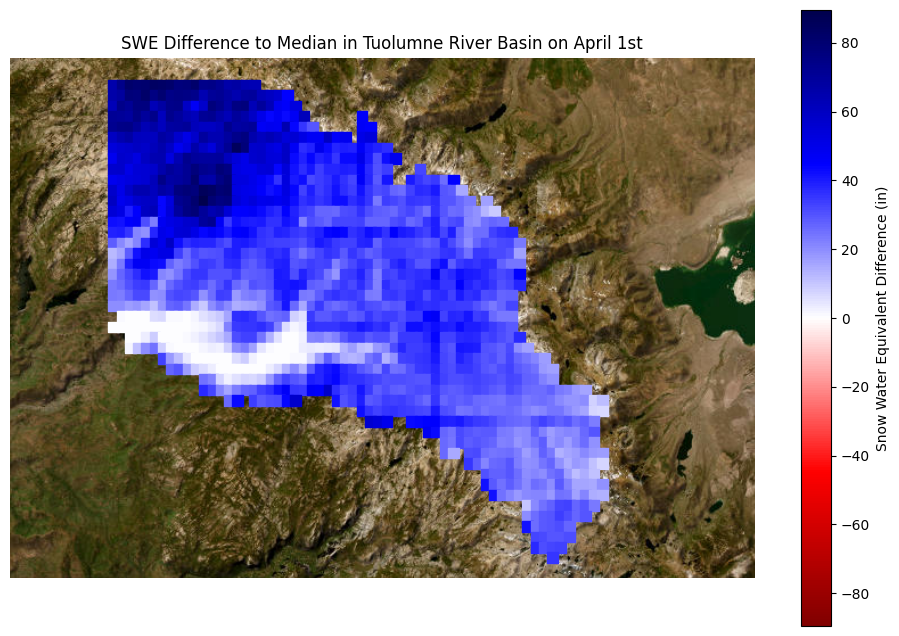

In [88]:
#Plot the SWE difference
basinname = 'Tuolumne'
output_res = 1000 #desired spatial resoultion in meters (m)
 # get files of interest
filename = [swedifffilename]
cmap = 'seismic_r' # use seismic for error, viridis or blues for preds/obs
var =  'SWE_diff_in' #'error'
savfig = True
variant = 'World_Imagery'
markersize = 60
swethres = 0.1
plttitle = 'SWE Difference to Median in Tuolumne River Basin on April 1st'

SWEdiff = SSWEET.SpatialAnalysis(filename, basinname, output_res, markersize, cmap, var,variant,swethres,plttitle, pltfig = True, savfig=False)

# 5. Investigate the differences between median and current basin snow conditions

In [89]:
#get elevation data for each pixel in the basin, this may take a few moments
SWEdiff_elev = get_Elevation.extract_terrain_data_threaded(SWEdiff,basinname, output_res)
SWEdiff_elev.head()

Calculating dataframe bounding box
-121 36 -118 40
Retrieving Copernicus 90m DEM tiles


  0%|          | 0/20 [00:00<?, ?it/s]

There are 20 tiles in the watershed
Determining Grid Cell Spatial Features


  0%|          | 0/1497 [00:00<?, ?it/s]

Job complete for getting geospatial metadata, putting into dataframe


0it [00:00, ?it/s]

Saving  dataframe in files/ASO/Tuolumne


,swe_m,swe_in,cen_lat,cen_lon,median_SWE_m,median_SWE_in,SWE_diff_in,SWE_diff_m,Elevation_m,Slope_Deg,Aspect_Deg
location,,,,,,,,,,,
Tuolumne_1000M_38.19_-119.8,1.661788,65.424767,38.19,-119.80,0.0,0.0,65.424767,1.661788,2677,4,0
Tuolumne_1000M_38.19_-119.79,1.866228,73.473572,38.19,-119.79,0.0,0.0,73.473572,1.866228,2578,6,0
Tuolumne_1000M_38.19_-119.78,2.073248,81.623993,38.19,-119.78,0.0,0.0,81.623993,2.073248,2673,8,184
Tuolumne_1000M_38.19_-119.77,2.042744,80.423035,38.19,-119.77,0.0,0.0,80.423035,2.042744,2652,8,120
Tuolumne_1000M_38.19_-119.76,2.052284,80.798645,38.19,-119.76,0.0,0.0,80.798645,2.052284,2681,24,306


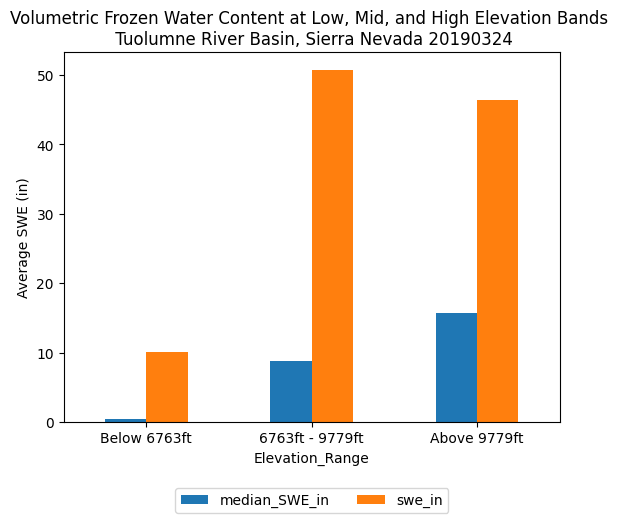

In [95]:
incols = ['median_SWE_in', "swe_in"]
#outcols =['Volume_Difference', 'Median_Volume', 'Observed_Volume']
outcols =['median_SWE_in', "swe_in"]
ncol = 3
output_res = 1000
region = 'Sierra Nevada'

Title = f'Volumetric Frozen Water Content at Low, Mid, and High Elevation Bands \n {basinname} River Basin, {region} {date}'
save = True
figname = f"Figures/ASO/{basinname}/{output_res}M/{basinname}_ElevationVol_{date}.png"

Depthdf = SSWEET.barplot(SWEdiff_elev, incols, outcols, output_res, ncol, Title, save, figname)

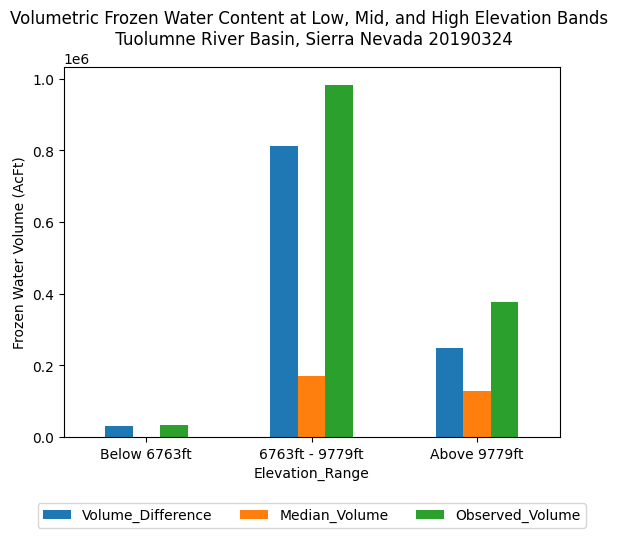

In [96]:

incols = ['median_SWE_in', "swe_in"]
outcols =['Volume_Difference', 'Median_Volume', 'Observed_Volume']
region = 'Sierra Nevada'
ncol = 3
output_res = 1000
Title = f'Volumetric Frozen Water Content at Low, Mid, and High Elevation Bands \n {basinname} River Basin, {region} {date}'
save = True
figname = f"Figures/ASO/{basinname}/{output_res}M/{basinname}_ElevationVol_{date}.png"

Vdf = SSWEET.barplot(SWEdiff_elev, incols, outcols, output_res, ncol, Title, save, figname)